# Training a simple CNN model in Tensorflow for Tornado Detection

This notebook steps through how to train a simple CNN model using a subset of TorNet.

This will not produce a model with any skill, but simply provides a working end-to-end example of how to set up a data loader, build, and fit a model


In [1]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES

In [6]:
# Create basic dataloader
# This option loads directly from netcdf files, and will be slow and IO bound
# To speed up training, either
#     build as a tensorflow_dataset , (see tornet/data/tfds/tornet/README.md)
#     cache dataset first , or
#     use tf.data.Dataset.load on a pre-saved dataset

# Location of tornet
data_root = 'C:/Users/mjhig/tornet_2013'

# Get training data from 2018
data_type='train'
years = [2013,2014,2015,2016,2017,2018]

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1,random_state=1234)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds = create_tf_dataset(file_list,variables=ALL_VARIABLES,n_frames=1) 

# (Optional) Save data for faster reloads (makes copy of data!)
#ds.save('tornet_sample.tfdataset') 


In [3]:
# If saved with ds.save(...), just load that model
#ds = tf.data.Dataset.load('tornet_sample.tfdataset')

In [4]:
# If data was registered in tensorflow_dataset, use that
# env variable TFDS_DATA_DIR should point to location of this resaved dataset
#import tensorflow_datasets as tfds
#import tornet.data.tfds.tornet.tornet_dataset_builder # registers 'tornet'

#data_type='train'
#years = [2018,]
#ds = tfds.load('tornet',split='+'.join(['%s-%d' % (data_type,y) for y in years]))

In [7]:
import tornet.data.preprocess as pp
from tornet.data import preprocess as tfpp

# Preprocess

# add 'coordinates' variable used by CoordConv layers
#ds = ds.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
     
# Take only last time frame
ds = ds.map(pp.remove_time_dim)

# Split sample into inputs,label
ds = ds.map(tfpp.split_x_y)

# (Optional) add sample weights
# weights={'wN':1.0,'w0':1.0,'w1':1.0,'w2':2.0,'wW':0.5}
# ds = ds.map(lambda x,y:  tfpp.compute_sample_weight(x,y,**weights) )

ds = ds.prefetch(tf.data.AUTOTUNE)
ds=ds.batch(32)

In [125]:
model.save_weights('model.weights.h5')


In [126]:
# # Basic loader
data_type='test'
years = [2013,2014,2015,2016,2017,2018]

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1,random_state=123)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds_test = create_tf_dataset(file_list,variables=ALL_VARIABLES) 


# preprocess
# ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))


In [127]:
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)   
ds_test=ds_test.batch(32)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[:,['Precision','Recall','pr_auc']].plot()

In [ ]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, BatchNormalization,
    Flatten, Input, Concatenate, Lambda, ReLU
)
from tornet.data.constants import CHANNEL_MIN_MAX

# ----------------------------
# **Input Processing**
# ----------------------------

input_vars = ALL_VARIABLES

# TF convention is B,L,W,H
inputs = {v: Input(shape=(120, 240, 2), name=v) for v in input_vars}

# Normalize inputs
norm_layers = []
for v in input_vars:
    min_max = np.array(CHANNEL_MIN_MAX[v])  # [2,]

    # Choose mean, var to get approximate [-1,1] scaling
    var = ((min_max[1] - min_max[0]) / 2) ** 2  # scalar
    var = np.array(2 * [var])  # [n_sweeps,]
    offset = (min_max[0] + min_max[1]) / 2  # scalar
    offset = np.array(2 * [offset])  # [n_sweeps,]

    norm_layers.append(
        keras.layers.Normalization(mean=offset, variance=var, name=f'Normalized_{v}')
    )

# Concatenate normed inputs along the channel dimension
x = Concatenate(axis=-1, name='Concatenate1')(
    [l(inputs[v]) for l, v in zip(norm_layers, input_vars)]
)

# Function to replace NaNs
def replace_nan(x):
    return tf.where(tf.math.is_nan(x), -3.0, x)

# Replace background (NaN) with -3
x = Lambda(replace_nan, name="ReplaceNan")(x)


# ----------------------------
# **CoordConv Implementation**
# ----------------------------

def add_coord_channels(tensor):
    """Adds x and y coordinate channels to the input tensor."""
    batch_size, height, width, _ = tf.shape(tensor)[0], tf.shape(tensor)[1], tf.shape(tensor)[2], tf.shape(tensor)[3]

    # Generate coordinate grids normalized between [-1, 1]
    x_coords = tf.linspace(-1.0, 1.0, width)
    y_coords = tf.linspace(-1.0, 1.0, height)

    x_coords = tf.tile(tf.expand_dims(x_coords, axis=0), [height, 1])
    y_coords = tf.tile(tf.expand_dims(y_coords, axis=1), [1, width])

    x_coords = tf.expand_dims(x_coords, axis=0)  # Shape: (1, H, W)
    y_coords = tf.expand_dims(y_coords, axis=0)  # Shape: (1, H, W)

    x_coords = tf.tile(x_coords, [batch_size, 1, 1])  # Shape: (B, H, W)
    y_coords = tf.tile(y_coords, [batch_size, 1, 1])  # Shape: (B, H, W)

    x_coords = tf.expand_dims(x_coords, axis=-1)  # Shape: (B, H, W, 1)
    y_coords = tf.expand_dims(y_coords, axis=-1)  # Shape: (B, H, W, 1)

    # Concatenate coordinate channels to the original tensor
    return tf.concat([tensor, x_coords, y_coords], axis=-1)

# **Apply CoordConv at the Start**
x = Lambda(add_coord_channels, name="CoordConv")(x)


# ----------------------------
# **CoordConv Block Definition**
# ----------------------------

def CoordConvBlock(inputs, filters=64, dropout_rate=0.3, name="CoordConvBlock"):
    """Creates a CoordConv block with Conv2D, BatchNorm, ReLU, MaxPool, and Dropout."""

    # First 3x3 CoordConv Layer
    x = Conv2D(filters, (3, 3), padding='same', name=f"{name}_Conv1")(inputs)
    x = BatchNormalization(name=f"{name}_BN1")(x)
    x = ReLU(name=f"{name}_ReLU1")(x)
    x = Conv2D(filters, (3, 3), padding='same', name=f"{name}_Conv2")(x)
    x = BatchNormalization(name=f"{name}_BN2")(x)
    x = ReLU(name=f"{name}_ReLU2")(x)

    # MaxPooling and Dropout
    x = MaxPooling2D((2, 2), name=f"{name}_MaxPool")(x)
    #x = Dropout(dropout_rate, name=f"{name}_Dropout")(x)

    return x


# ----------------------------
# **Feature Extraction**
# ----------------------------

# Apply CoordConv Blocks
x = CoordConvBlock(x, filters=64, name="Block1")
x = CoordConvBlock(x, filters=128, name="Block2")
#x = CoordConvBlock(x, filters=256, name="Block3")

# ----------------------------
# **Final Prediction Layers**
# ----------------------------

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)


# Output layer (Binary classification: Tornadic or Non-Tornadic)
y = Dense(1, activation='sigmoid', name='TornadoLikelihood')(x)

# ----------------------------
# **Compile Model**
# ----------------------------

model = keras.Model(inputs=inputs, outputs=y, name='TornadoDetector_CoordConv')
model.summary()


Model: "TornadoDetector_CoordConv"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ DBZ (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VEL (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ KDP (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RHOHV (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ZDR (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WIDTH (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_DBZ      │ (None, 120, 240,  │          0 │ DBZ[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_VEL      │ (None, 120, 240,  │          0 │ VEL[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_KDP      │ (None, 120, 240,  │          0 │ KDP[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_RHOHV    │ (None, 120, 240,  │          0 │ RHOHV[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_ZDR      │ (None, 120, 240,  │          0 │ ZDR[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_WIDTH    │ (None, 120, 240,  │          0 │ WIDTH[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1        │ (None, 120, 240,  │          0 │ Normalized_DBZ[0… │
│ (Concatenate)       │ 12)               │            │ Normalized_VEL[0… │
│                     │                   │            │ Normalized_KDP[0… │
│                     │                   │            │ Normalized_RHOHV… │
│                     │                   │            │ Normalized_ZDR[0… │
│                     │                   │            │ Normalized_WIDTH… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ReplaceNan (Lambda) │ (None, 120, 240,  │          0 │ Concatenate1[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CoordConv (Lambda)  │ (None, 120, 240,  │          0 │ ReplaceNan[0][0]  │
│                     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 296,337 (1.13 MB)

 Trainable params: 295,561 (1.13 MB)

 Non-trainable params: 776 (3.03 KB)

In [35]:
import optuna
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall,BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy,BinaryFocalCrossentropy
from tensorflow.keras.initializers import GlorotUniform

# Function to reset model weights
def reset_weights(model):
    """Reset model weights using GlorotUniform initialization."""
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
            layer.set_weights([
                GlorotUniform()(w.shape).numpy() if w.shape.rank > 1 else tf.zeros_like(w)
                for w in layer.get_weights()
            ])

tf.random.set_seed(42)
# Define the objective function for Optuna
    
#optimizer = AdamW(learning_rate=0.0002281875239379196, weight_decay=0.0008319142931225579)
optimizer = AdamW()
loss = BinaryFocalCrossentropy()
#model.load_weights('model.weights.h5')

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        AUC(curve='PR', name='pr_auc'),
        AUC(name='AUC'),
        BinaryAccuracy(name='BinaryAccuracy'),
        Precision(name='Precision'),
        Recall(name='Recall')
    ]
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='pr_auc',
    patience=2,
    mode='max',
    restore_best_weights=True
)

# Train the model
history = model.fit(
    ds,
    epochs=20,  # Limit epochs for tuning
    steps_per_epoch=10,
    callbacks=[early_stopping],
)

Epoch 1/20


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*'}
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - AUC: 0.4757 - BinaryAccuracy: 0.6343 - Precision: 0.0235 - Recall: 0.3502 - loss: 0.2379 - pr_auc: 0.0402
Epoch 2/20
 5/10 ━━━━━━━━━━━━━━━━━━━━ 1:12 14s/step - AUC: 0.6235 - BinaryAccuracy: 0.8886 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.1043 - pr_auc: 0.1472

KeyboardInterrupt: 

<Axes: >

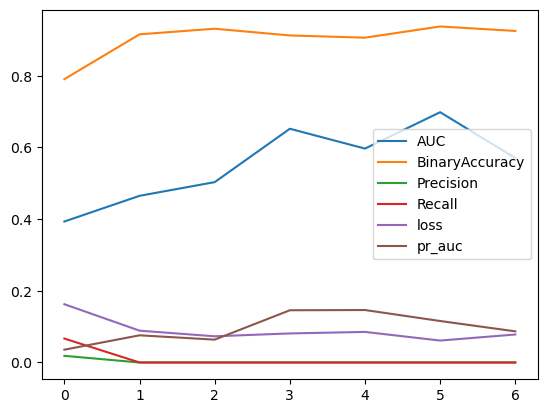

In [25]:
history_frame = pd.DataFrame(history.history)
history_frame.plot()

In [26]:
model.save("my_model3.keras")


In [ ]:
# Evaluate
import tornet.metrics.keras.metrics as km
metrics = [keras.metrics.AUC(curve='PR',name='PRAUC'),
           km.BinaryAccuracy(from_logits=True,name='BinaryAccuracy'), 
           km.Precision(from_logits=True,name='Precision'),
           ]
model.compile(metrics=metrics)

# steps=10 for demo purposes
model.evaluate(ds_test,steps=10)

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 120, 240, 12), dtype=float32, sparse=False, name=keras_tensor_18>',)
  • kwargs={'mask': 'None'}